Objetivo general: Determinar los factores pronóstico de mortalidad en pacientes con Neumonía grave por Covid 19 ingresados en la Unidad de Cuidados Intensivos.
Se realizó una investigación analítica transversal, en la Unidad de Cuidados Intensivos del Hospital Militar Comandante Manuel Fajardo Rivero, desde  enero 2023 a noviembre 2025. 
El estudio fue realizado en toda la población constituida por los pacientes ingresados en la UCI con diagnóstico de Neumonía Grave por Covid 19 en el año 2021.

Datos Recogidos:

1. Datos Demográficos
- Edad
- Sexo
2. APP: Antecedentes Patológicos Personales
- APPHTA: Hipertensión arterial 
- APPDM: Diabetes mellitus 
- APPEPOC: Enfermedad Pulmonar Obstructiva Crónica 
- APPPERC: Enfermedad Renal Crónica
- APPCardiopatía Isquémica
- APPAsma Bronquial
- APP obesidad:
3. Medicamentos/Tratamientos
- Dobutamina
- Norepinefrina
4. Condiciones Clínicas Agudas
- TEP: Tromboembolismo pulmonar 
- Insuficiencia renal aguda
- Shock séptico
- ARDS: Síndrome de dificultad respiratoria aguda
- Sobreinfección Bacteriana
5. Marcadores de Laboratorio
- Dimero D: Proteína en sangre que indica coagulación anormal
- PCR: Proteína C-reactiva
- Ferritina: Proteína que almacena hierro
- LDH: Lactato deshidrogenasa 
- Índice neutrófilos/linfocitos
6. Parámetros Clínicos y de Gravedad
- APACHE II al ingreso: Puntuación pronóstica en UCI (evalúa edad, signos vitales y laboratorio).
- PaO2/FiO2 al ingreso: Ratio oxigenación.
7. Factores de Tratamiento
- Días de VAM: Días en ventilación asistida mecánica
- Días de retardo en recibir atención médica
8. Desenlace.
- Egreso: Estado al salir del hospital (supervivencia vs mortalidad).



__________________________________________________________________________________________________________________________________________________

Importar las bibliotecas principales para el proyecto:
- pandas para la manipulación y análisis de datos (lectura de archivos, dataframes, etc.).
- matplotlib.pyplot y seaborn se emplean para visualizaciones de datos y exploración visual (gráficas, histogramas, distribuciones).
- numpy añade funcionalidades numéricas (arrays, operaciones vectorizadas).
- De sklearn:
    * train_test_split para dividir el conjunto de datos en entrenamiento y prueba.
    * GridSearchCV para búsqueda sistemática de hiperparámetros mediante validación cruzada.
    * RFE para selección recursiva de características.
    * Métricas y utilidades de evaluación (por ejemplo, confusion_matrix, ConfusionMatrixDisplay).
- scipy.stats.pointbiserialr es usada para medir correlación entre variables continuas y la variable binaria de mortalidad (egreso).
- xgboost proporciona el modelo base XGBoost para la selección de características.

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV  
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import   confusion_matrix ,ConfusionMatrixDisplay , precision_score , recall_score , f1_score
from sklearn.tree import DecisionTreeClassifier


Se cargan los datos en un dataframe de pandas y se renombran las columnas para facilitar el trabajo

In [3]:
data_set = pd.read_excel("./base_datos_pr.xlsx" ,sheet_name="Hoja1" )
data_set.drop("Nombre y apellidos" , axis="columns" , inplace=True)
new_columns = {'Edad':"edad", 'Sexo':"sexo",'APPCardiopatia Isquemica':"APPCI",'APPAsma Bronquial':"APPAB",'Dobutamina':"dobutamina",
 'Norepinefrina':"norepinefrina", 'Insuficiencia renal aguda':"ins_renal_aguda",'Shock séptico':"shock_septico",
 'Sobreinfección Bacteriana  ':"sobreinf_bac",'Días de VAM':"dias_vam",'Egreso':"egreso",'Dimero D':"dimero_d",'APP obesidad ':"APPO",
 'APACHE II al ingreso':"apache_II",'PaO2/FiO2 al ingreso':"PaO2/Fio2",'Ferritina':"ferritina",'Días de retardo en recibir atencion medica ':"dias_retraso",
 'índice neutrofilos /linfositos  ':"neutro/linfo"}
data_set.rename(columns=new_columns ,inplace=True)
data_set.columns

Index(['edad', 'sexo', 'APPHTA', 'APPDM', 'APPEPOC', 'APPERC', 'APPCI',
       'APPAB', 'dobutamina', 'norepinefrina', 'TEP', 'ins_renal_aguda',
       'shock_septico', 'sobreinf_bac', 'dias_vam', 'egreso', 'dimero_d',
       'ARDS', 'APPO', 'apache_II', 'PaO2/Fio2', 'PCR', 'ferritina',
       'dias_retraso', 'neutro/linfo', 'LDH'],
      dtype='object')

Se identifican las características numéricas y categóricas para el análisis. Además los valores faltantes en los datos se rellenan con la mediana.
* Valores faltantes:
  - casos 18 y 20 : PCR , ferritina , días de retraso , neutrofilos/linfositos , LDH 

In [4]:
categorical_cols = [col  for col in data_set.columns  if data_set[col].nunique()==2 and col != 'egreso']
numeric_cols = [col for col in data_set.columns if col not in categorical_cols and col != 'egreso']
for column in numeric_cols:
    data_set[column]=data_set[column].fillna( value=data_set[column].median())
data_set['sexo']=data_set['sexo']-1
data_set.describe()

,edad,sexo,APPHTA,APPDM,APPEPOC,APPERC,APPCI,APPAB,dobutamina,norepinefrina,...,dimero_d,ARDS,APPO,apache_II,PaO2/Fio2,PCR,ferritina,dias_retraso,neutro/linfo,LDH
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,...,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,63.159091,0.409091,0.530303,0.265152,0.159091,0.181818,0.219697,0.159091,0.159091,0.348485,...,578.287879,0.757576,0.310606,15.962121,172.204545,60.174242,456.727273,5.212121,3.934848,762.765152
std,17.622344,0.493539,0.500982,0.443095,0.367154,0.387164,0.415619,0.367154,0.367154,0.478306,...,647.114258,0.430182,0.464505,14.996898,77.021633,24.749276,226.627577,2.011533,0.805798,401.819713
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.000000,0.000000,0.000000,0.000000,54.000000,23.000000,56.000000,1.000000,2.300000,213.000000
25%,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,95.000000,1.000000,0.000000,12.000000,104.500000,46.000000,320.000000,4.000000,3.300000,452.500000
50%,61.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,350.500000,1.000000,0.000000,15.000000,145.500000,54.000000,451.500000,5.000000,4.000000,654.000000
75%,76.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,736.250000,1.000000,1.000000,17.000000,226.250000,65.000000,571.000000,6.000000,4.425000,993.000000
max,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3450.000000,1.000000,1.000000,180.000000,345.000000,156.000000,1421.000000,11.000000,6.400000,2340.000000


Se calcula el desbalance de la variable objetivo y se divide el dataframe en el conjunto de entrenamiento (train_set) y el conjunto de prueba (test_set) usando muestreo estratificado para mantener la proporción de la variable objetivo.

In [5]:
fallecidos=data_set["egreso"][data_set.egreso==1].sum()
print(f"fallecidos: {fallecidos/len(data_set)*100}%")
train_set, test_set = train_test_split(
    data_set,
    test_size=0.20,        
    random_state=25,      
    stratify=data_set['egreso']  #mantener la misma proporcion del target en train_set y test_set
)




fallecidos: 68.18181818181817%


Se analiza la distribución y se buscan posibles valores erróneos en las variables numéricas

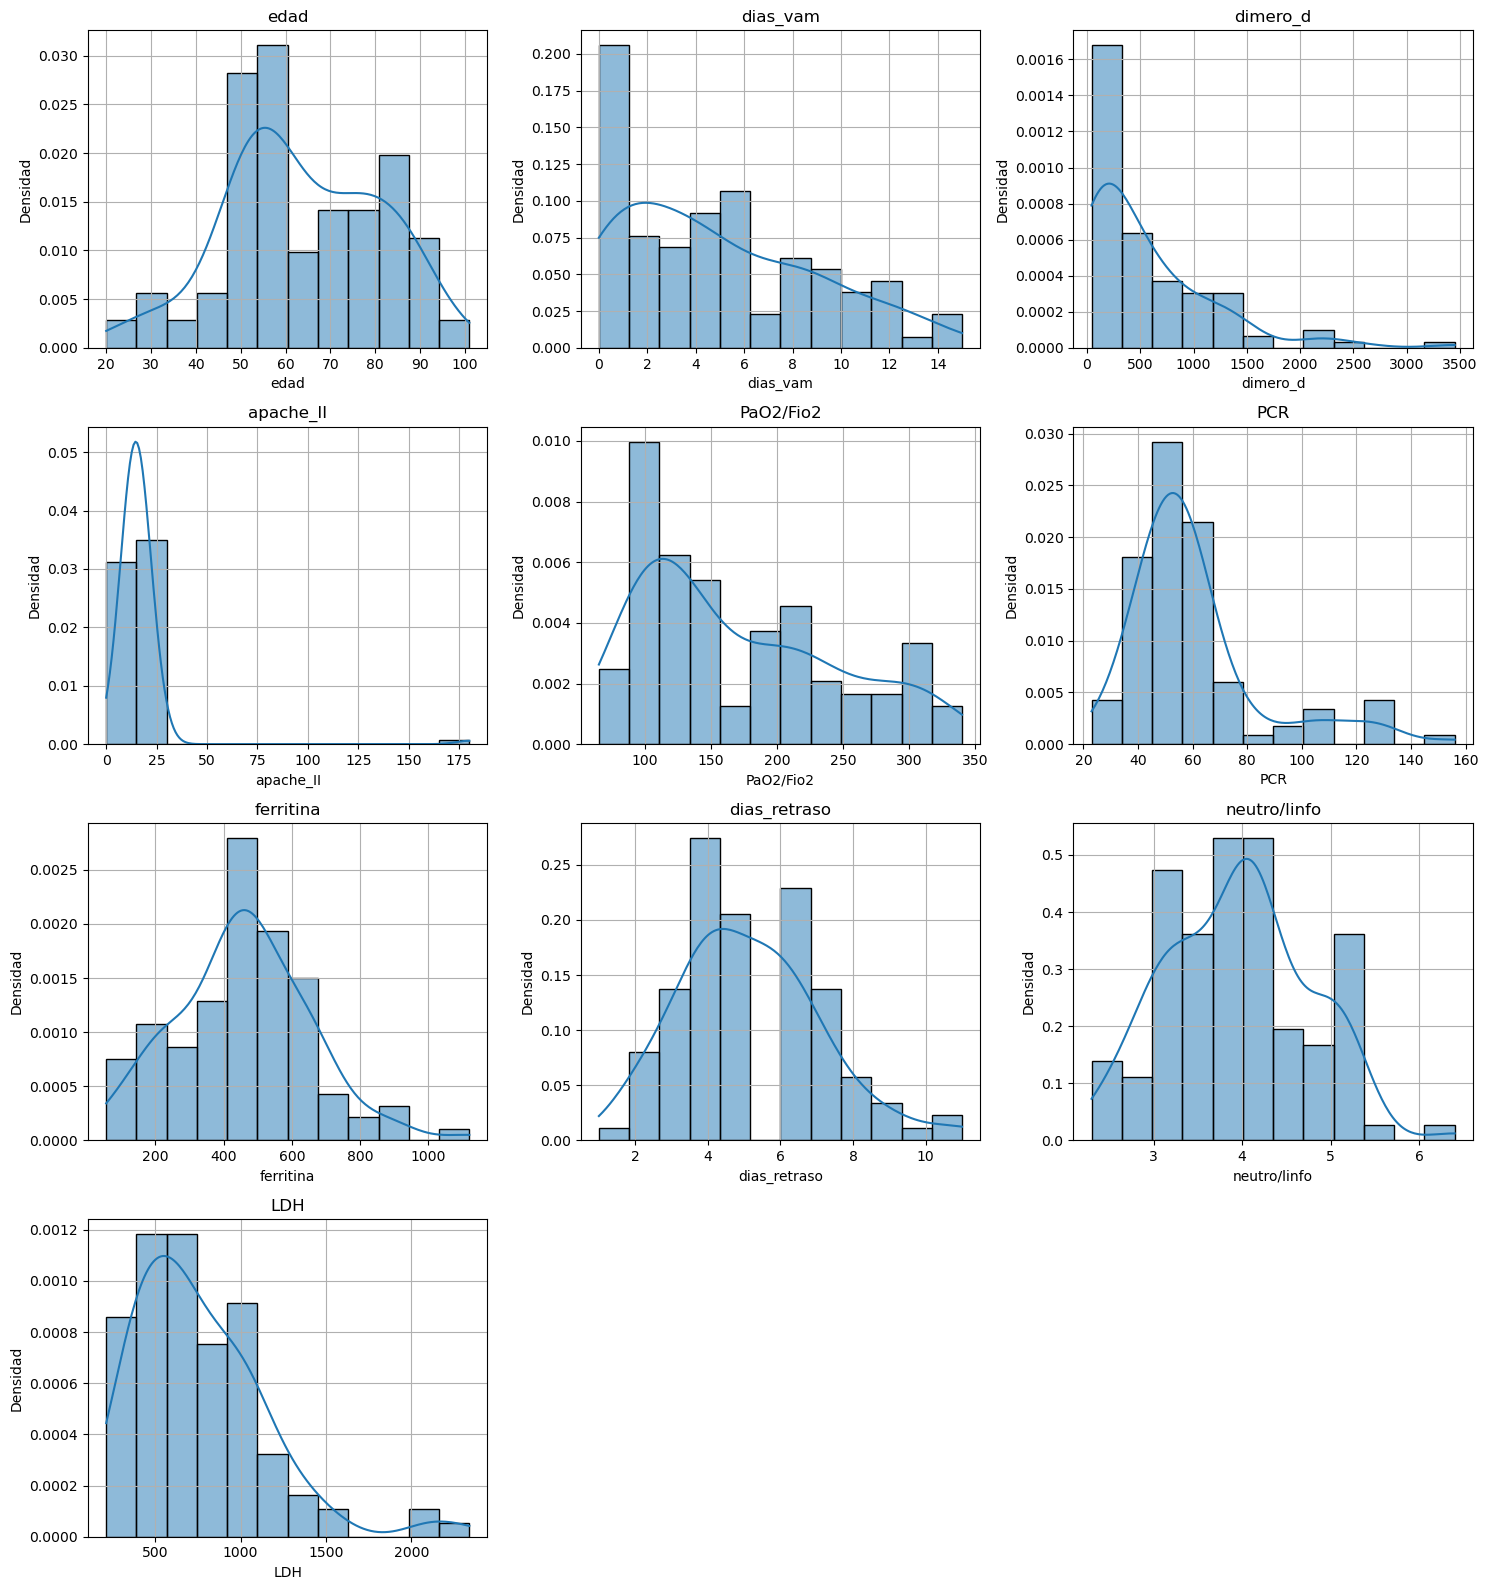

In [6]:
import math
n = len(numeric_cols)
cols = 3  
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()  
for i, col in enumerate(numeric_cols):
    sns.histplot(train_set[col], kde=True, stat='density', bins=12, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    axes[i].grid(True)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

El apache II tiene un rango de valores registrado de 0-71 , valores por encima de 40 son muy infrecuentes y un apache II de 0 es prácticamente imposible dado la condición de los pacientes (neumonía grave) . La gráfica muestra que existen valores erróneos para este campo por lo que se descartan esos casos (además coinciden con los casos con valores faltantes: 18 y 20).

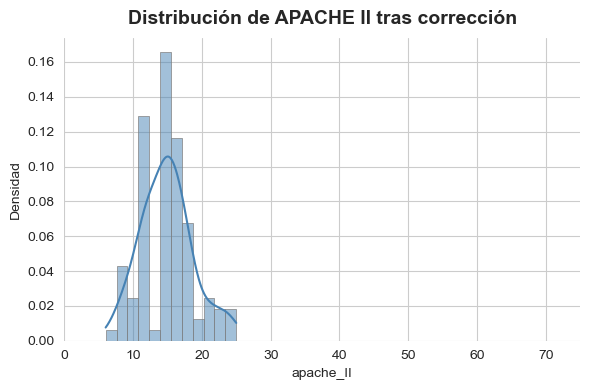

In [7]:
train_set.drop(train_set[(train_set["apache_II"]>70 )|( train_set["apache_II"]<=0)].index , inplace=True)
test_set.drop(test_set[(test_set["apache_II"]>70 )|( test_set["apache_II"]<=0)].index , inplace=True)

sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(
    train_set["apache_II"],
    kde=True,            
    stat="density",    
    bins=12,             
    color="steelblue",   
    edgecolor="gray",
    linewidth=0.5
)
plt.title("Distribución de APACHE II tras corrección", fontsize=14, weight="bold", pad=10)
plt.xlabel("apache_II", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.grid(True)
plt.xlim(0, 75)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

Correlación punto-biserial de las variables numéricas con la variable objetivo.

In [8]:
correlaciones = {}
for col in numeric_cols:
        correlacion, p_valor = pointbiserialr(train_set[col], train_set["egreso"])
        correlaciones[col] = correlacion
df_correlaciones = pd.DataFrame({
    "Atributo": correlaciones.keys(),
    "Correlación": correlaciones.values()
}).sort_values(by="Correlación", key=abs, ascending=False)     
df_correlaciones

,Atributo,Correlación
0,edad,0.622984
3,apache_II,0.469226
9,LDH,0.440840
6,ferritina,0.383054
4,PaO2/Fio2,-0.344719
2,dimero_d,0.337309
5,PCR,0.214489
7,dias_retraso,0.154588
8,neutro/linfo,0.081138
1,dias_vam,0.021007


Se calcula la matriz de correlación de las variables numéricas para identificar si existe una correlación fuerte entre pares de predictores ,
pues estos pueden ser eliminados durante la eliminación recursiva (RFE) y tener importancia para el problema. 

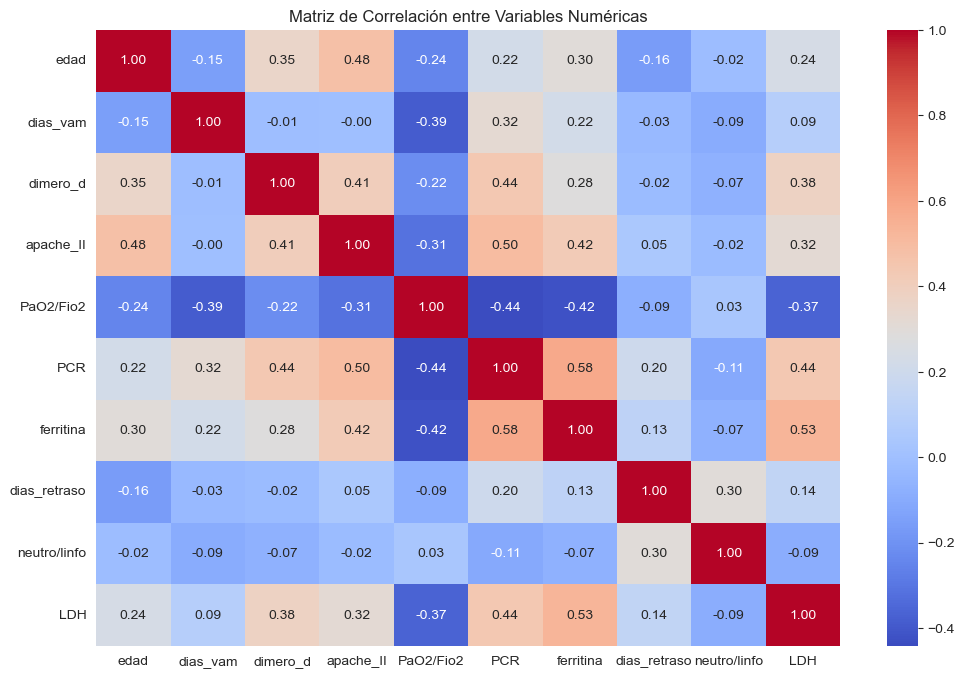

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_set[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

Balance de las características categóricas.

In [10]:
frecuencias= pd.DataFrame([] , index=categorical_cols)
for col in frecuencias.index:
    frecuencias.loc[col ,"frecuencia_absoluta"]=train_set[col].sum()
    frecuencias.loc[col ,"frecuencia_relativa"]=frecuencias.loc[col ,"frecuencia_absoluta"]/(len(train_set))*100
    frecuencias.loc[col ,"tasa_mortalidad %"]=train_set.loc[train_set[col].astype(bool) , 'egreso'].sum()/frecuencias.loc[col ,"frecuencia_absoluta"]*100 

frecuencias

,frecuencia_absoluta,frecuencia_relativa,tasa_mortalidad %
sexo,42.0,40.776699,61.904762
APPHTA,55.0,53.398058,89.090909
APPDM,22.0,21.359223,90.909091
APPEPOC,18.0,17.475728,77.777778
APPERC,19.0,18.446602,94.736842
APPCI,25.0,24.271845,92.000000
APPAB,14.0,13.592233,21.428571
dobutamina,11.0,10.679612,100.000000
norepinefrina,33.0,32.038835,93.939394
TEP,25.0,24.271845,100.000000


Representación gráfica.

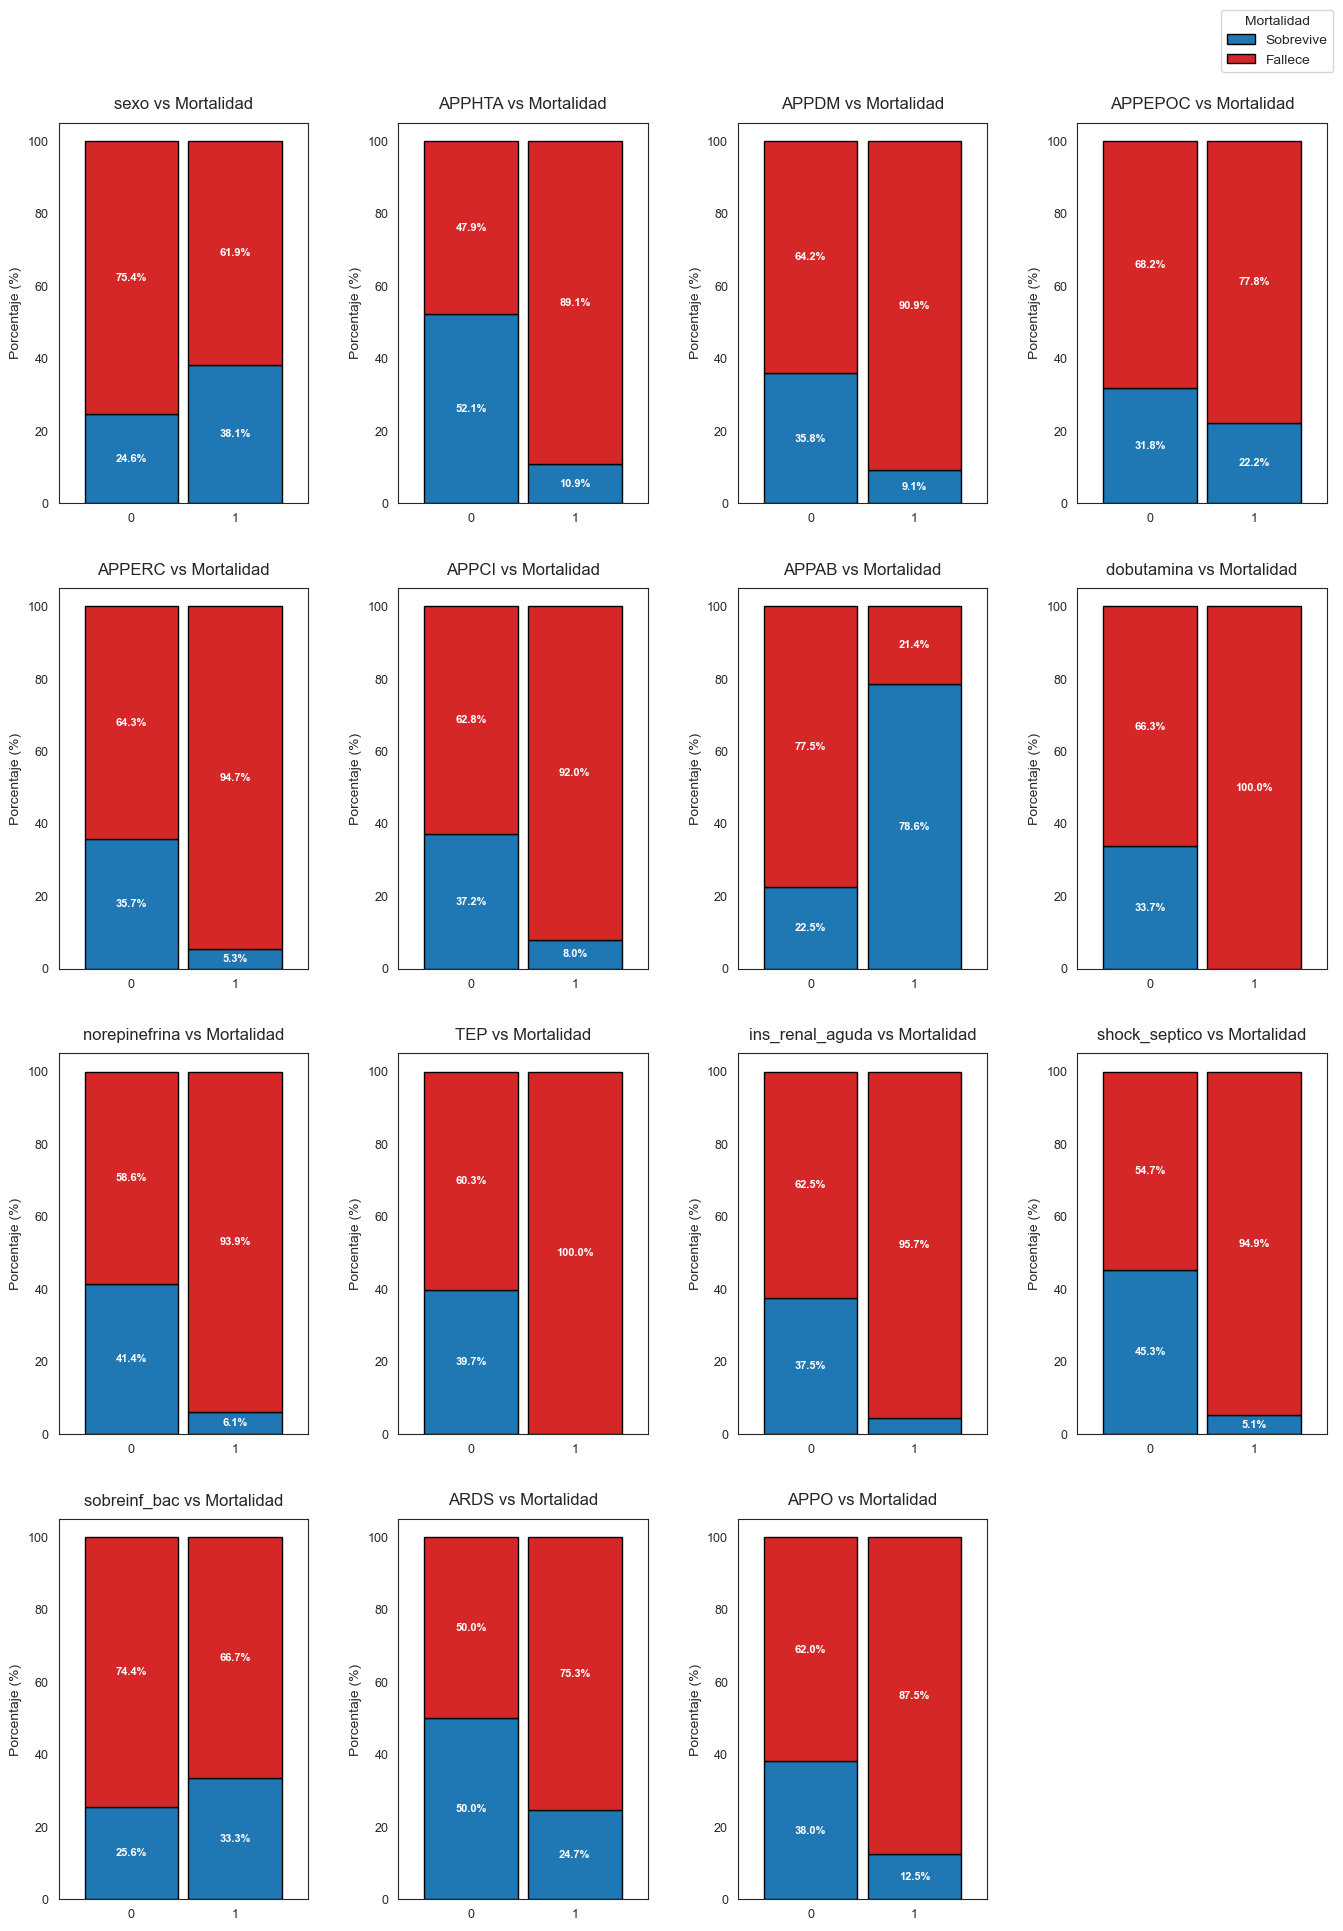

In [11]:
sns.set_style("white")
n_rows = (len(categorical_cols) + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(14, 5 * n_rows))
axes = axes.flatten() 
colores = ["#1f77b4", "#d62728"]  # Azul: Sobrevive, Rojo: Fallece
for i, categ in enumerate(categorical_cols):
    tabla = pd.crosstab(train_set[categ], train_set["egreso"], normalize="index") * 100
    ax = tabla.plot(
        kind="bar",
        stacked=True,
        color=colores,
        ax=axes[i],
        edgecolor="black",
        width=0.9 
    )
    ax.set_title(f"{categ} vs Mortalidad", fontsize=12, pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje (%)", fontsize=10)
    ax.legend_.remove()  
    ax.tick_params(axis="x", labelsize=9, rotation=0)
    ax.tick_params(axis="y", labelsize=9)
    for barra in ax.patches:
        width, height = barra.get_width(), barra.get_height()
        x, y = barra.get_xy()
        if height > 5: 
            ax.text(
                x + width/2, 
                y + height/2, 
                f"{height:.1f}%", 
                ha="center", 
                va="center", 
                color="white",
                fontsize=8,
                fontweight="bold"
            )
fig.legend(
    ["Sobrevive", "Fallece"],
    title="Mortalidad",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10
)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)  
plt.show()

Entrenamiento del modelo:
    Para encontrar las características más importantes se usa el método de eliminación recursiva RFE con un XGBoost como modelo base para calcular la importancia de cada característica , además para encontrar los hiperparámetos adecuados se usa GridSearchCV con 5 particiones para la validación cruzada y el área bajo la curva roc (AUC-ROC) como métrica para evaluar las combinaciones de parámetros.

In [12]:

X_test = test_set.drop(["egreso"] , axis="columns")
y_test = test_set.egreso
X_train  = train_set.drop(["egreso"]  , axis="columns")
y_train = train_set.egreso
scale = (y_train == 0).sum() / (y_train == 1).sum() 
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42 ,
    scale_pos_weight=scale # Ajuste de peso para clases desbalanceadas (mas fallecidos que sobrevivientes)
)
rfe = RFE(
    estimator=xgb_base,
    step=1, 
    verbose=0
)
parametros = {
    
    # Hiperparámetros de XGBoost (dentro de RFE)
   'estimator__n_estimators':  [30,40,50,60,70,80],
   'estimator__max_depth':     [5,6,4,3],
   'estimator__learning_rate': [ 0.1, 0.3],              
    'estimator__colsample_bytree': [ 0.8, 1.0],       
    'estimator__reg_alpha': [0.3,0.6],    
    'estimator__reg_lambda': [1,2],  
    

    # Número de características finales que RFE debe conservar
    'n_features_to_select':[5,6,7,8,9,10]
}

grid_rfe = GridSearchCV(
    estimator=rfe,
    param_grid=parametros,
    scoring="roc_auc",  
    cv=5,              
    n_jobs=-1,        
    verbose=2
)
grid_rfe.fit(X_train, y_train)
print("Mejor ROC-AUC (CV):", grid_rfe.best_score_)
print("Mejores parámetros:", grid_rfe.best_params_)
best_rfe = grid_rfe.best_estimator_
#Caracteristicas seleccionadas por RFE
selected_features = X_train.columns[best_rfe.support_]
selected_features

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Mejor ROC-AUC (CV): 0.9289342403628119
Mejores parámetros: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 40, 'estimator__reg_alpha': 0.6, 'estimator__reg_lambda': 1, 'n_features_to_select': 6}


Index(['edad', 'TEP', 'shock_septico', 'apache_II', 'ferritina', 'LDH'], dtype='object')

Resultados sobre el Conjunto de Pruebas. Matriz de Confusión , precision , recall y f1-score

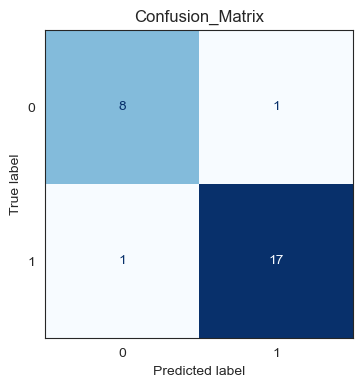

1 -> Precision: 0.9444, Recall: 0.9444, F1: 0.9444
0 -> Precision: 0.8889, Recall: 0.8889, F1: 0.8889


In [13]:
xgb_base = best_rfe.estimator_
xgb_base.fit(X_train[selected_features] , y_train)
y_pred = xgb_base.predict(X_test[selected_features])
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_title("Confusion_Matrix")
plt.show()

prec_pos = precision_score(y_test, y_pred, pos_label=1)
rec_pos = recall_score(y_test, y_pred, pos_label=1)
f1_pos = f1_score(y_test, y_pred, pos_label=1)
print(f"1 -> Precision: {prec_pos:.4f}, Recall: {rec_pos:.4f}, F1: {f1_pos:.4f}")

prec_neg = precision_score(y_test, y_pred, pos_label=0)
rec_neg = recall_score(y_test, y_pred, pos_label=0)
f1_neg = f1_score(y_test, y_pred, pos_label=0)
print(f"0 -> Precision: {prec_neg:.4f}, Recall: {rec_neg:.4f}, F1: {f1_neg:.4f}")

Casos que el modelo ha clasificado mal:

In [14]:
test_set[y_pred!=y_test][selected_features.union(['egreso'])]

,LDH,TEP,apache_II,edad,egreso,ferritina,shock_septico
41,459.0,0,9,79,0,85.0,0
42,540.0,0,10,49,1,148.0,0


Ranking de características del modelo.  

In [15]:

rfe_ranking = best_rfe.ranking_  
df_ranking = pd.DataFrame({
    'feature': X_train.columns,
    'rfe_rank': rfe_ranking
})
xgb_full = best_rfe.estimator_
xgb_full.fit(X_train , y_train)
df_ranking['importancia_xgb'] = xgb_full.feature_importances_
df_ranking = df_ranking.sort_values(by=['rfe_rank' , 'importancia_xgb'], ascending=[True ,False]).reset_index(drop=True)
df_ranking

,feature,rfe_rank,importancia_xgb
0,edad,1,0.223763
1,apache_II,1,0.146902
2,TEP,1,0.121937
3,LDH,1,0.100595
4,ferritina,1,0.053888
5,shock_septico,1,0.051760
6,dimero_d,2,0.042543
7,PaO2/Fio2,3,0.025121
8,dias_vam,4,0.044998
9,APPHTA,5,0.001731


Entrenamiento del modelo sin los atributos : edad y apache_II (atributos con mayor correlacion)

In [22]:
X_test = test_set.drop(["egreso", 'edad','apache_II'] , axis="columns")
y_test = test_set.egreso
X_train  = train_set.drop(["egreso", 'edad','apache_II']  , axis="columns")
y_train = train_set.egreso
scale = (y_train == 0).sum() / (y_train == 1).sum() 
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42 ,
    scale_pos_weight=scale # Ajuste de peso para clases desbalanceadas
rfe = RFE(
    estimator=xgb_base,
    step=1, 
    verbose=0
)
parametros = {
    
    # Hiperparámetros de XGBoost (dentro de RFE)
   'estimator__n_estimators':  [30,40,50,60,70,80],
   'estimator__max_depth':     [5,6,4,3],
   'estimator__learning_rate': [ 0.1, 0.3],              
    'estimator__colsample_bytree': [ 0.8, 1.0],       
    'estimator__reg_alpha': [0.3,0.6],    
    'estimator__reg_lambda': [1,2],  
    

    # Número de características finales que RFE debe conservar
    'n_features_to_select':[10]
}

grid_rfe = GridSearchCV(
    estimator=rfe,
    param_grid=parametros,
    scoring="roc_auc",  
    cv=5,              
    n_jobs=-1,        
    verbose=2
)
grid_rfe.fit(X_train, y_train)
print("Mejor ROC-AUC (CV):", grid_rfe.best_score_)
print("Mejores parámetros:", grid_rfe.best_params_)
best_rfe = grid_rfe.best_estimator_
#Caracteristicas seleccionadas por RFE
selected_features = X_train.columns[best_rfe.support_]
selected_features
""" Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Mejor ROC-AUC (CV): 0.9062131519274377
Mejores parámetros: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.3, 'estimator__max_depth': 4, 'estimator__n_estimators': 40, 'estimator__reg_alpha': 0.3, 'estimator__reg_lambda': 2, 'n_features_to_select': 6} """

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Mejor ROC-AUC (CV): 0.9056689342403628
Mejores parámetros: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.3, 'estimator__max_depth': 5, 'estimator__n_estimators': 70, 'estimator__reg_alpha': 0.6, 'estimator__reg_lambda': 2, 'n_features_to_select': 10}


" Fitting 5 folds for each of 2304 candidates, totalling 11520 fits\nMejor ROC-AUC (CV): 0.9062131519274377\nMejores parámetros: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.3, 'estimator__max_depth': 4, 'estimator__n_estimators': 40, 'estimator__reg_alpha': 0.3, 'estimator__reg_lambda': 2, 'n_features_to_select': 6} "

Resultados:

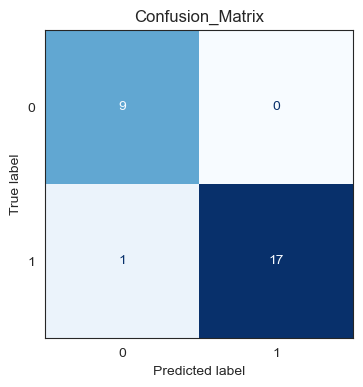

1 -> Precision: 1.0000, Recall: 0.9444, F1: 0.9714
0 -> Precision: 0.9000, Recall: 1.0000, F1: 0.9474


In [23]:
xgb_base = best_rfe.estimator_
xgb_base.fit(X_train[selected_features] , y_train)
y_pred = xgb_base.predict(X_test[selected_features])
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_title("Confusion_Matrix")
plt.show()

prec_pos = precision_score(y_test, y_pred, pos_label=1)
rec_pos = recall_score(y_test, y_pred, pos_label=1)
f1_pos = f1_score(y_test, y_pred, pos_label=1)
print(f"1 -> Precision: {prec_pos:.4f}, Recall: {rec_pos:.4f}, F1: {f1_pos:.4f}")

prec_neg = precision_score(y_test, y_pred, pos_label=0)
rec_neg = recall_score(y_test, y_pred, pos_label=0)
f1_neg = f1_score(y_test, y_pred, pos_label=0)
print(f"0 -> Precision: {prec_neg:.4f}, Recall: {rec_neg:.4f}, F1: {f1_neg:.4f}")

In [24]:
test_set[y_pred!=y_test][selected_features.union(['egreso'])]

,APPEPOC,APPHTA,LDH,PaO2/Fio2,TEP,dias_vam,dimero_d,egreso,ferritina,ins_renal_aguda,shock_septico
42,0,0,540.0,265,0,0,67,1,148.0,0,0


Ranking:

In [25]:
rfe_ranking = best_rfe.ranking_  
df_ranking = pd.DataFrame({
    'feature': X_train.columns,
    'rfe_rank': rfe_ranking
})
xgb_full = best_rfe.estimator_
xgb_full.fit(X_train , y_train)
df_ranking['importancia_xgb'] = xgb_full.feature_importances_
df_ranking = df_ranking.sort_values(by=['rfe_rank' , 'importancia_xgb'], ascending=[True ,False]).reset_index(drop=True)
df_ranking

,feature,rfe_rank,importancia_xgb
0,LDH,1,0.148666
1,APPHTA,1,0.113366
2,TEP,1,0.095728
3,shock_septico,1,0.062286
4,dias_vam,1,0.056861
5,dimero_d,1,0.042110
6,ins_renal_aguda,1,0.035752
7,ferritina,1,0.030774
8,PaO2/Fio2,1,0.026138
9,APPEPOC,1,0.019509
